In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

## 生成数据

In [2]:
# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

In [8]:
# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

In [11]:
# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

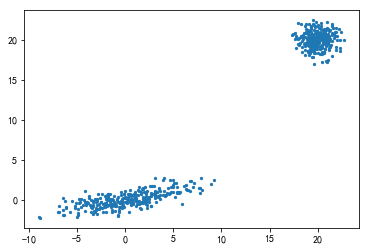

In [32]:
plt.scatter(X_train[:,0], X_train[:,1],s=5);

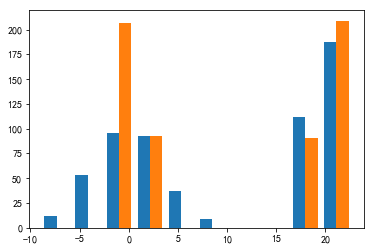

In [13]:
plt.hist(X_train);

## 高斯混合模型估计

In [14]:
# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [60]:
## 精度是协方差矩阵的逆
np.linalg.inv(clf.precisions_[0])

array([[ 11.87681963,   2.45885701],
       [  2.45885701,   0.99502525]])

In [61]:
np.linalg.inv(clf.precisions_cholesky_[0])

array([[ 3.4462762 ,  0.71348228],
       [ 0.        ,  0.69711425]])

## 绘制生成的模型对每个点的概率估计

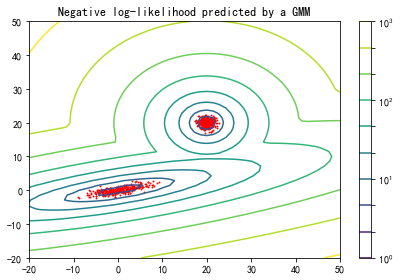

In [56]:
# display predicted scores by the model as a contour plot
x = np.linspace(-20., 50.)
y = np.linspace(-20., 50.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

#CS = plt.contourf(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),alpha=0.5,cmap=plt.cm.Blues,levels=np.logspace(0, 3, 10),)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),levels=np.logspace(0, 3, 10))
#CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.colorbar()
plt.scatter(X_train[:, 0], X_train[:, 1], .8, c='r')

plt.title('Negative log-likelihood predicted by a GMM')
plt.tight_layout()
plt.axis('tight')
plt.show()

## 高斯混合模型的选择

In [66]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [67]:
# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

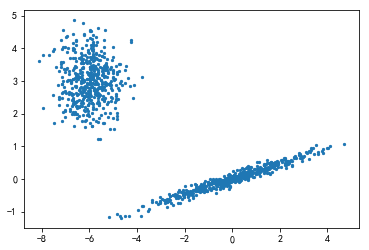

In [70]:
plt.scatter(X[:,0], X[:,1],s=5);

### 训练多个模型
分别遍历混合个数和混合类型

In [81]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)

Automatically created module for IPython interactive environment


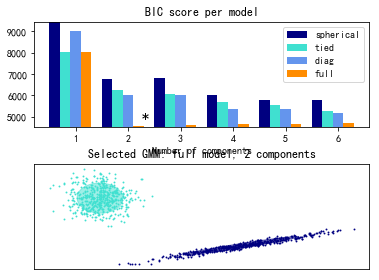

In [65]:
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## 实战

In [107]:
from scipy.io import loadmat
data = loadmat('ex8data1.mat')
X = data['X']

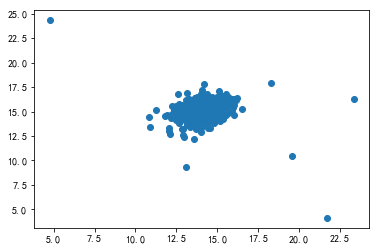

In [108]:
plt.scatter(X[:,0], X[:,1]);

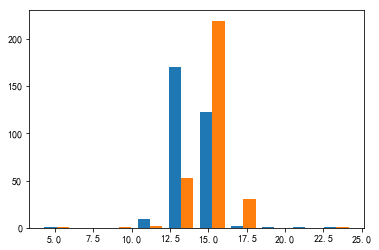

In [109]:
plt.hist(X);

In [110]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

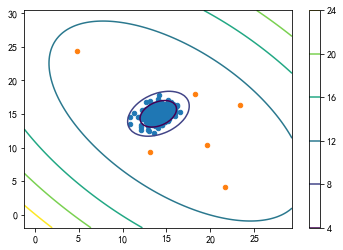

In [49]:
y = gmm.predict(X)
plt.scatter(X[y==0,0], X[y==0,1],s=20)
plt.scatter(X[y==1,0], X[y==1,1],s=20)

eps = 5
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
xx, yy = np.meshgrid(np.linspace(xmin-eps, xmax+eps, 100), np.linspace(ymin-eps, ymax+eps, 100))
Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z)
plt.colorbar();

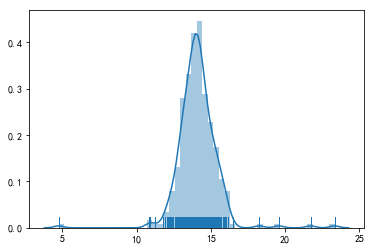

In [34]:
import seaborn as sns
sns.distplot(X[:, 0], rug=True);

In [50]:
data2 = loadmat('ex8data2.mat')
X = data2['X']

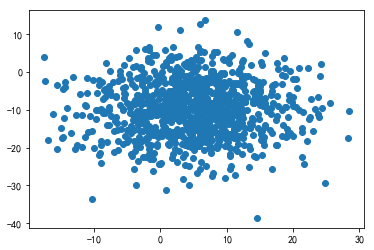

In [51]:
plt.scatter(X[:,0], X[:,1]);

In [73]:
from sklearn import decomposition
fa = decomposition.FactorAnalysis(n_components=2, max_iter=100)
x_fa = fa.fit_transform(X)

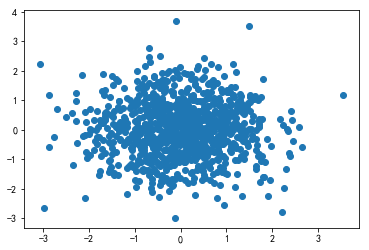

In [74]:
plt.scatter(x_fa[:,0], x_fa[:,1]);

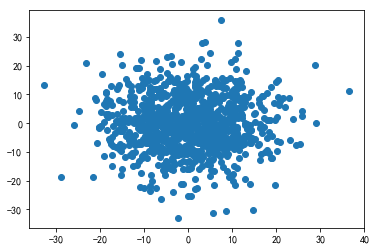

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_ = pca.fit_transform(X)
plt.scatter(x_[:,0], x_[:,1]);

In [66]:
pca.explained_variance_ratio_

array([ 0.13197958,  0.12662529])

In [75]:
gmm = GaussianMixture(n_components=2)
gmm.fit(x_fa)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

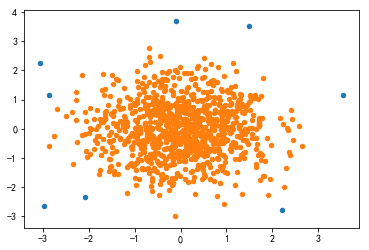

In [93]:
eps = 0.001
y = np.exp(gmm.score_samples(x_fa))
plt.scatter(x_fa[y<=eps,0], x_fa[y<=eps,1],s=20)
plt.scatter(x_fa[y>eps,0], x_fa[y>eps,1],s=20)

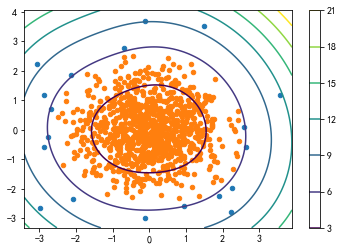

In [106]:
eps = 0.0035
y = np.exp(gmm.score_samples(x_fa))
plt.scatter(x_fa[y<=eps,0], x_fa[y<=eps,1],s=20)
plt.scatter(x_fa[y>eps,0], x_fa[y>eps,1],s=20)

eps =0
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
xx, yy = np.meshgrid(np.linspace(xmin-eps, xmax+eps, 100), np.linspace(ymin-eps, ymax+eps, 100))
Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z)
plt.colorbar();